Check Python version

In [1]:
!python --version

Python 3.9.18


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [4]:
train_df = pd.read_csv(file_name)

In [5]:
train_df.shape

(144, 2)

In [6]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [7]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [9]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [10]:
train_df[target_col] = train_df[target_col].astype(float)

In [11]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

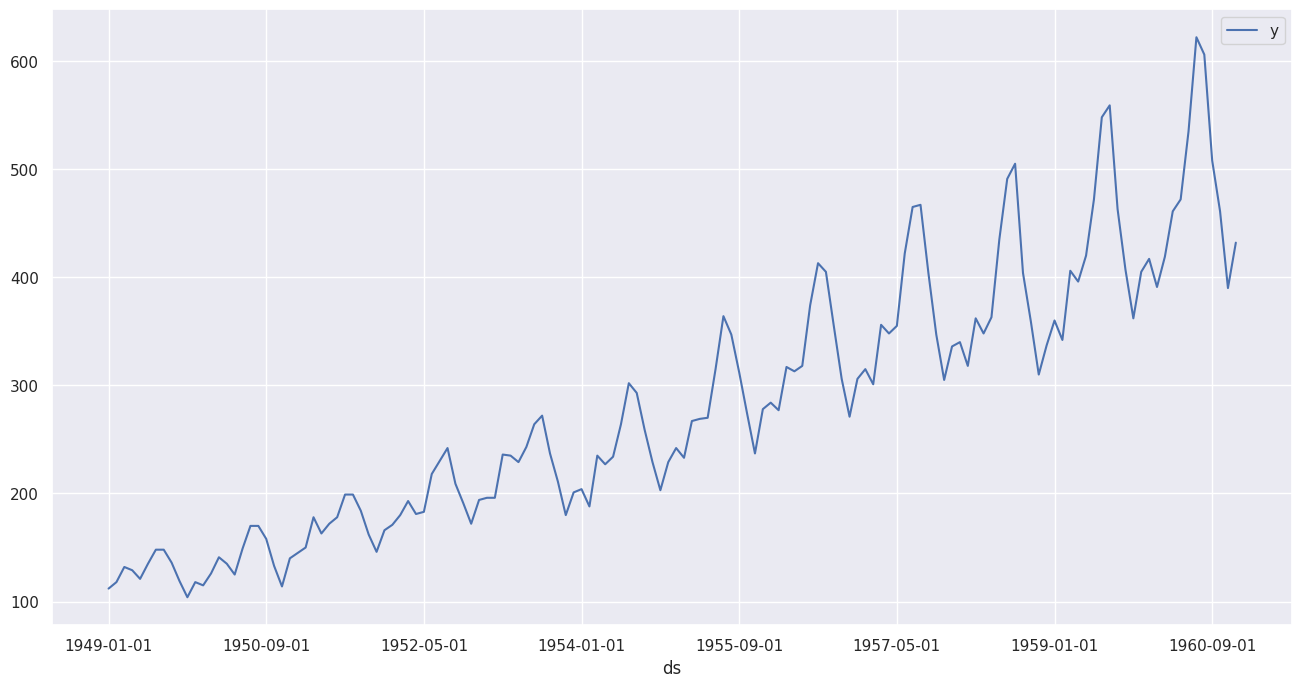

In [12]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [13]:
train_data = []

In [14]:
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [16]:
# Default model request
# model_request = {
#     'type': 'meta_lr',
#     'scorers': ['smape', 'mase'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer'},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_naive'},
#             {'type': 'darts_seasonalnaive'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autoets'},
#         ],
#     },
# }

# Onboard NeuralProphet customized model request
# np_external_model_request = {
#     'params': {
#       'changepoints_range': 0.2,
#       'epochs': 2,
#       'growth': 'off'
#     },
#     'metrics': [],
#     'type': 'neuralprophet',
# }
# np_external_model_request = None

# Customized model request
# model_request = {
#     'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
#     'scorers': ['mase', 'smape'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer'},
#             {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_naive'},
#             {'type': 'darts_seasonalnaive'},
#             {'type': 'darts_autotheta'},
#             {'type': 'stats_autotheta'},
#             {'type': 'darts_autoets'},
#             {'type': 'stats_autoets'},
#             {'type': 'darts_autoarima'},
#             {'type': 'stats_autoarima'},
#             # {'type': 'darts_tbats'},
#             # {'type': 'darts_linearregression'},
#             {'type': 'darts_lightgbm',
#              'params': {
#                  'lags': 12,
#                  'output_chunk_length': 6,
#                  'verbose': -1
#             }},
#             {'type': 'darts_rnn',
#              'params': {
#                  'model': 'LSTM',
#                  'hidden_dim': 10,
#                  'n_rnn_layers': 3
#             }},
#             # {'type': 'neuralprophet',
#             #  'external_params': np_external_model_request
#             # }  # Onboard NeuralProphet external service
#         ],
#     },
# }

This is for JSON model_request

In [17]:
# file_path = 'model_request.json'
# # For writing the model request to a json file
# with open(file_path, 'r') as file:
#     model_request = json.load(file)

This is for YAML model_request

In [18]:
file_path = 'model_request.yaml'
# For reading the model request from a yaml file
with open(file_path, 'r') as file:
    model_request = yaml.safe_load(file)

print(model_request)

{'type': 'meta_wa', 'scorers': ['mase', 'smape'], 'params': {'preprocessors': [{'type': 'dartsimputer'}, {'type': 'minmaxscaler'}], 'base_models': [{'type': 'darts_naive'}, {'type': 'darts_seasonalnaive'}, {'type': 'darts_autotheta'}, {'type': 'darts_autoets'}, {'type': 'darts_autoarima'}, {'type': 'darts_lightgbm', 'params': {'lags': 12, 'output_chunk_length': 6, 'verbose': -1}}, {'type': 'darts_rnn', 'params': {'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 3}}]}}


Train API JSON Payload

In [19]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [20]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [21]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [22]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [23]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 28.4 ms, sys: 10.6 ms, total: 38.9 ms
Wall time: 1min 11s


In [24]:
train_json_out = response.json()  # dict output
train_json_out

{'model': 'AgEBCGMQCABgEAgAkrMFABgAAACLswUAS7EAAD+AAGVsaZOMb5Rsb4xtlARhaZRzcmGUKIwudG2UTZNwbx94lEmMLmRtSWWMFW9pDHSMjHlDKCSUiQNK/0NulGQuLh9ld22TdGQoZHOUX2V5k2FhYZRplE4CUk7/KEt0AJRoiB9o/wCUlIDGxAMBamjRzsw1MpyZl9fUPTukoZ8IBm9sah+qpxAOd3Vy29lCPz0SD3h239zaQ0Gqp6Xl4ktJsrCtFh8UfXp4uLUeHIWDgOnnUE5Li4ny71hWU726IyEe8/BZVx/AvrskIouIhsbELSqTkY739V5cWZmXAP1mZGLLyDEvLB9satPROjc1npsEAgDU0js4oZ+dBgNsfXE1dVKUcm2UchtmjF90c2hhlCgAAYwucmUpaGxhlBtoaAFoCW5hwL8fHmiHAHSGBn1zb5RlZ2hoAWhzc2Z9iAQpaGgglEuJaF0fhSiNXSgAlGholCiUaIUoMGFofYhibGx3lG+UC2Roc5QfKHRzc3OMb3KBcnMQaXNTlAlpeHIuYWGUjHMUY2lJaSkfBV90ci5nYW5yfWGUaAZoX5RkhoFoKQGMkyMoS0+UTkoflJSDATEoS2IAAIyUZWhhaYxJKQU6aA1oaAFCawPogIgfICfAWWD4AJgxFa61TlXuho0mLcZeQ9zje4MbtLtUW/MfjAKbojpC2nN6ExqySzDIz2hvCKCoQEjgeV32/ZadNs4f1W51DqaLIyvDy2P8A5yjO9RK4uqCiiK7wlpi+pN4EBcfsLdQ6PCIjyjBpT5F3uV9Fh22vVbu02tzCxKrREvj64MfHJIqMsrRagMKoqpicGxpZW6UUmhydXVpb3BiKTIBaGgTAQAAaEgBdW5fZXKUaHOUAJRLgADghgAfaoxfdGmUTmJfR2FpeABxTXBjdHRlbmJjZZRyaWkAcHQNYV9zaRlfY2VzcmkcZWmACh9paQtsX2Fjb2R0EmhnD

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [25]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [26]:
model = train_json_out['model']

Forecast API JSON Payload

In [27]:
api_json = {
    'model': model,
    'data': dates
}

Build URL (same as train except for the endpoint)

In [28]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [29]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 25 ms, sys: 1.83 ms, total: 26.8 ms
Wall time: 445 ms


In [30]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1961-01-01', 436.1034280117432],
  ['1961-02-01', 424.4604379638601],
  ['1961-03-01', 463.7683887153828],
  ['1961-04-01', 472.68940675161446],
  ['1961-05-01', 477.9026599115807],
  ['1961-06-01', 528.9036577200194],
  ['1961-07-01', 586.4075949667869],
  ['1961-08-01', 582.1174941153195],
  ['1961-09-01', 511.7550998484011],
  ['1961-10-01', 464.76474418490585],
  ['1961-11-01', 412.03288413987264],
  ['1961-12-01', 449.35049335687495],
  ['1962-01-01', 452.6985910027201],
  ['1962-02-01', 440.09328698300885],
  ['1962-03-01', 480.6613554288243],
  ['1962-04-01', 489.2619849741491],
  ['1962-05-01', 494.29388049916076],
  ['1962-06-01', 547.2317019592874],
  ['1962-07-01', 605.5326442484156],
  ['1962-08-01', 601.1748652614722],
  ['1962-09-01', 529.1890107004252],
  ['1962-10-01', 480.7858374844978],
  ['1962-11-01', 426.8260500858388],
  ['1962-12-01', 465.13804069251]]}

Combine forecast dates and output

In [31]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [32]:
forecast_df.shape

(24, 2)

In [33]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [34]:
forecast_df.head()

,ds,y
0,1961-01-01,436.103428
1,1961-02-01,424.460438
2,1961-03-01,463.768389
3,1961-04-01,472.689407
4,1961-05-01,477.902660


In [35]:
forecast_df.tail()

,ds,y
19,1962-08-01,601.174865
20,1962-09-01,529.189011
21,1962-10-01,480.785837
22,1962-11-01,426.826050
23,1962-12-01,465.138041


Plot train and forecast side-by-side

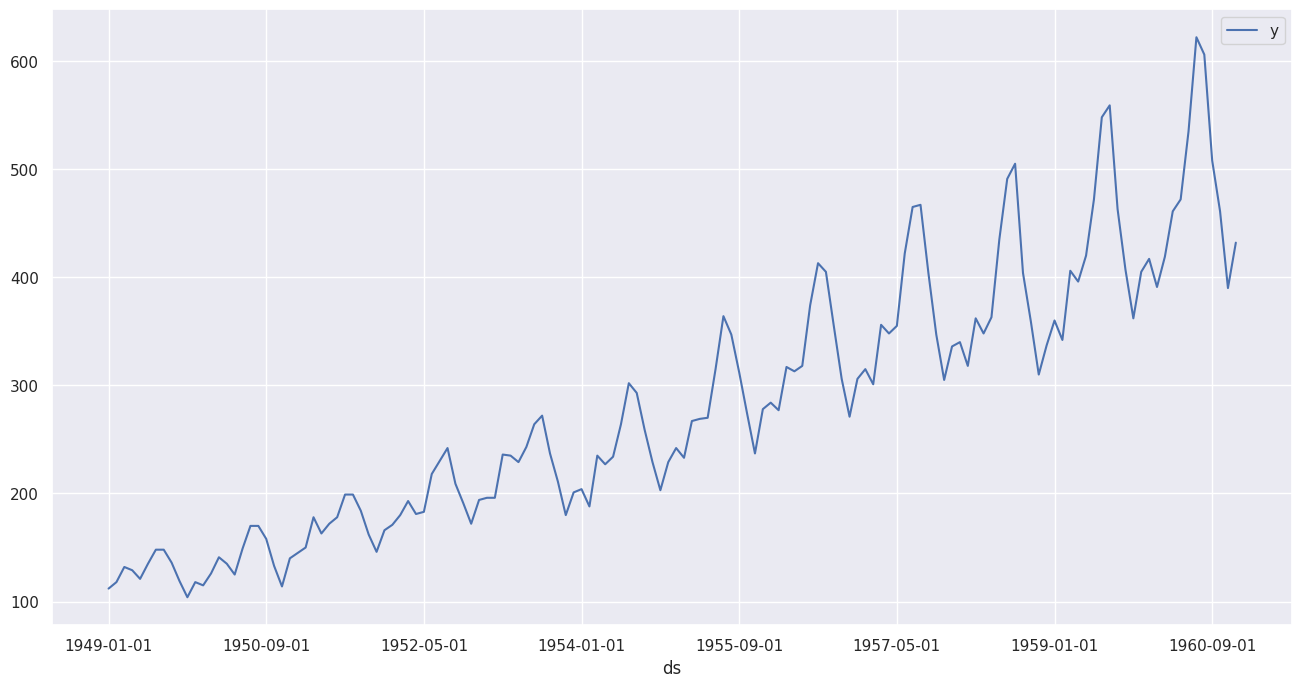

In [36]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

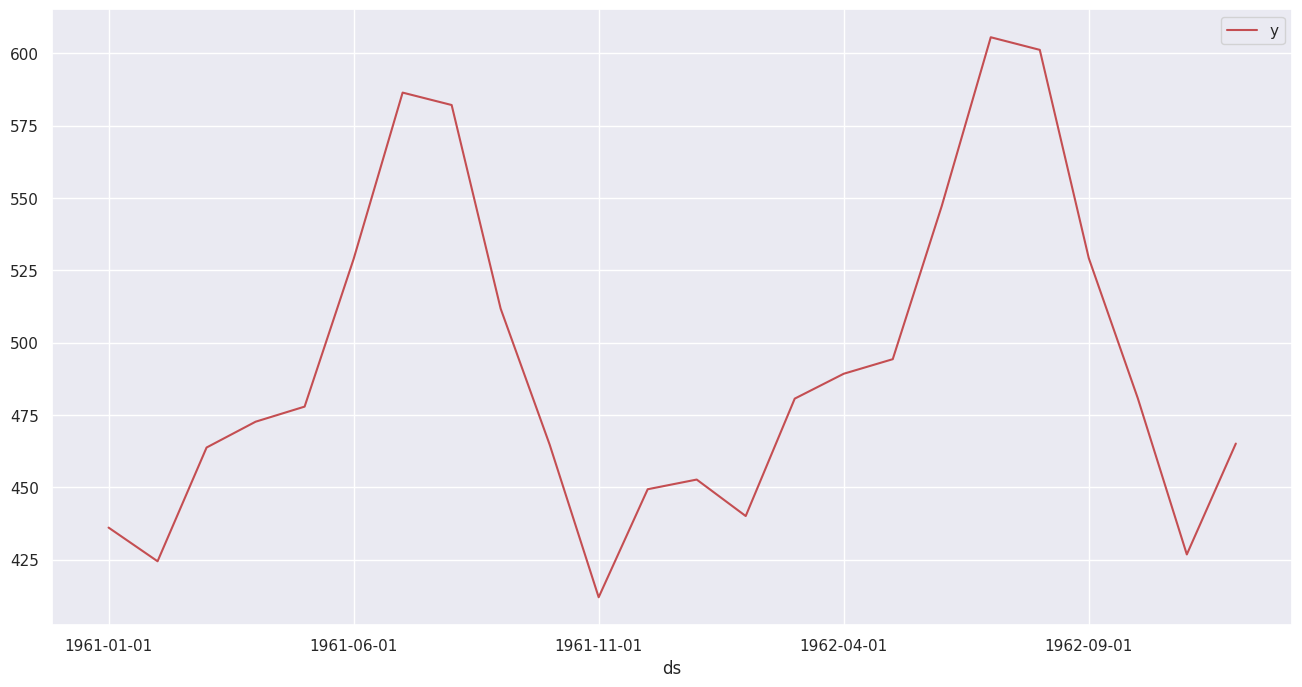

In [37]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and forecast sets

In [38]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [39]:
df.shape

(168, 3)

In [40]:
df.head()

,ds,y,color
0,1949-01-01,112.0,b
1,1949-02-01,118.0,b
2,1949-03-01,132.0,b
3,1949-04-01,129.0,b
4,1949-05-01,121.0,b


In [41]:
df.tail()

,ds,y,color
163,1962-08-01,601.174865,r
164,1962-09-01,529.189011,r
165,1962-10-01,480.785837,r
166,1962-11-01,426.826050,r
167,1962-12-01,465.138041,r


Plot combined train and forecast sets with the vertical black line as the cut-off

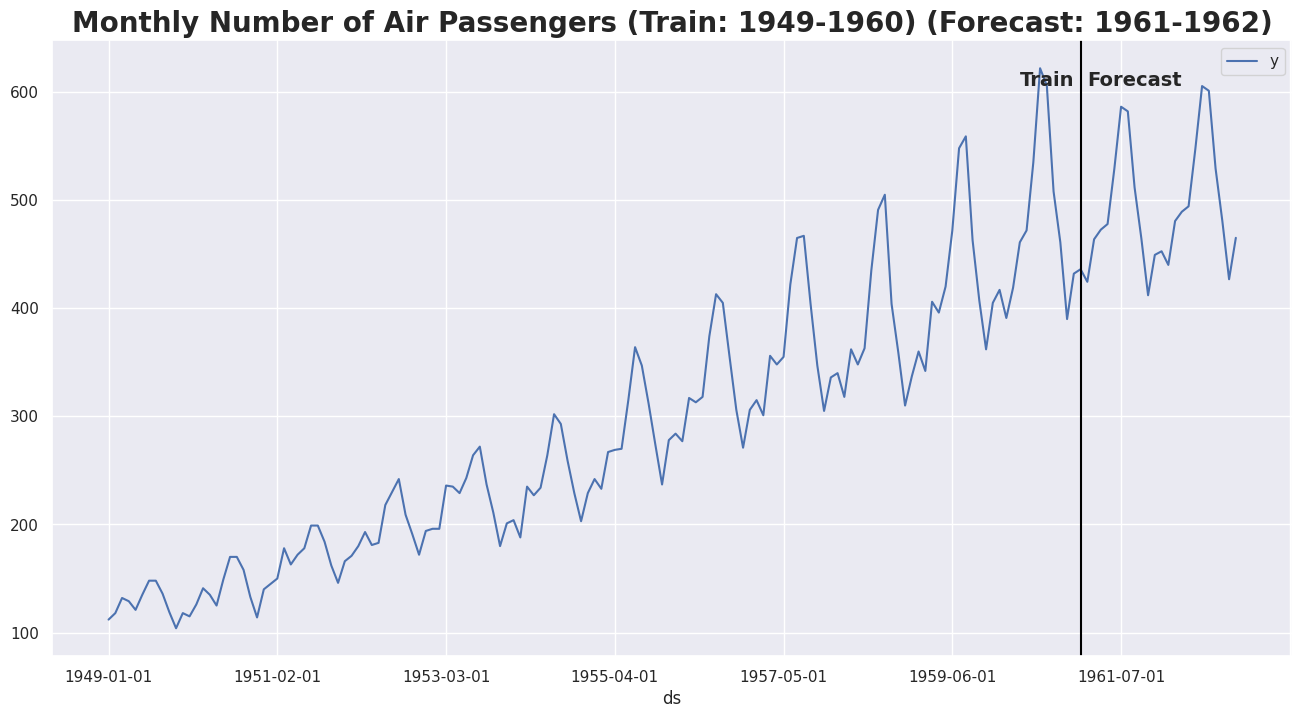

In [42]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Forecast: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();